### Trace simulation

In this notebook we will run the Euler-Maruyama method to simulate a particle under the action of a cubic perturbation

### Summary

- [1 - Packages and imports](#1)

- [2 - Simulation of a nanoparticle](#2)


<a name='1'></a> 
### 1. Packages and imports

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from non_linearity.environment import Particle
from non_linearity.simulation import simulation
import non_linearity.utils.constants as ct
from scipy import signal as sn


In [4]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

<a name='2'></a> 
### 2. Simulation of a nanoparticle

In [5]:
freq = 79e3
omega = 2*np.pi*freq
T = 1 / freq
max_time = 500 * T
M = 500
delta_t = 2e-7
N_time = int(max_time / delta_t)
t = np.linspace(0, max_time, int(N_time))
gamma = 0#13578.7501
env = Particle(omega, gamma, radius=73e-9)

In [41]:
def extract_central_freq(freq, psds):
    indexes = np.argwhere((freq>65000) & (freq <95000))
    freq_cropped, power_cropped = freq[indexes], psds[indexes]
    p0 =  [39103.417023, 2*np.pi*80000.0, 13000.2758744481, 0]
    ans, cov = curve_fit(lorentzian, 2*np.pi*freq_cropped[:, 0], power_cropped[:,0], p0=p0, maxfev=10000)
    return ans[1], cov[1,1]


def lorentzian(omega,A,center,gamma,base):
    num = A*gamma
    den = (center**2-omega**2)**2+omega**2*gamma**2
    return num/den + base


def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[0]):
        freq, pxx = sn.welch(traces[i,:], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[1]))
        pxxs.append(pxx)
    return freq, np.array(pxxs)


def generate_traces(env, delta_t, N_time,  M, gain_range):
    cubic_variables = {i:{'gain': gain, 'traces': [], 
                          'freq': [], 'psd': [], 'psd_cubic': []} for i, gain in enumerate(gain_range)}
    print("-- Creating traces --")
    for key in tqdm(cubic_variables.keys()):
        cubic = np.zeros(shape=(M, N_time))
        for i in range(M):
            data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, cubic_variables[key]['gain']*(env.zp_x**3/env.zp_p), 0)
            data = np.array(data)
            cubic[i, :] = data
        cubic_variables[key]['traces'] = cubic
    print("-- Analysing and making PSD --")
    central_freqs, std_freqs = [], []
    for key in tqdm(list(cubic_variables.keys())):

        freq, pxx = psd(cubic_variables[key]['traces'], delta_t)
        freq, pxx_cubic = psd(np.power(cubic_variables[key]['traces'], 3), delta_t)
        cubic_variables[key]['freq'] = freq
        cubic_variables[key]['psd'] = pxx
        cubic_variables[key]['psd_cubic'] = pxx_cubic
#        plt.plot(freq, pxx[1,:])
#        plt.yscale('log')
#        plt.show()

#        delay_areas.append(pxx.sum(axis=1).mean())
#        areas_std.append(pxx.sum(axis=1).std())

    return cubic_variables

In [38]:
sim_gains = np.linspace(-6e6, 6e6, 100)
cubic_variables = generate_traces(env, delta_t, int(N_time), M, sim_gains)


-- Creating traces --


100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


-- Analysing and making PSD --


100%|██████████| 100/100 [09:52<00:00,  5.92s/it]


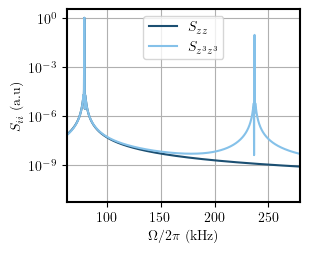

In [39]:
psd_z = cubic_variables[0]['psd'].mean(axis=0);
psd_z = psd_z/psd_z.max()
psd_zcubic = cubic_variables[0]['psd_cubic'].mean(axis=0)
psd_zcubic = psd_zcubic/psd_zcubic.max()
freq = cubic_variables[0]['freq']

gains = ['5052','0', '11332']

colors = ['#1B4F72', '#2E86C1', '#85C1E9']
ax = plt.gca()
ax.figure.set_size_inches(3, 2.5, forward=True)


ax.plot(freq/1e3, psd_z, color=colors[0])
ax.plot(freq/1e3, psd_zcubic, color=colors[2])
ax.set_xlim([63, 3*93])
#ax.set_ylim([1e-3, 3*1e0])

ax.set_yscale('log')
ax.legend([r'$S_{zz}$', r'$S_{z^3z^3}$'])
ax.set(xlabel=r'$\Omega/2\pi$ (kHz)')
ax.set(ylabel=r'$S_{ii}$ (a.u)')

ax.grid()
plt.savefig('../plots/psd_of_cubic.png', bbox_inches='tight', dpi=300)

plt.show()